In [1]:
CONFIDENCE = 0.95
ALPHA = 1-CONFIDENCE
LOAD_MODEL_PATH = 'models/AGC_model02_LAC.pth'

In [2]:
#
import os, sys
sys.path.append(os.path.abspath('src/'))
working_dir = os.getcwd()
data_dir = working_dir + '/data/AE_maxillofacial/preprocessed/'

#
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
device = 'cuda'

# Operaciones aleatorias
import random

# Manipulación de datos
import numpy as np
import pandas as pd

# Manejo y edición de imágenes
from PIL import Image

#
import matplotlib.pyplot as plt

# Evaluación y partición de modelos
from sklearn.model_selection import train_test_split

# Modelos, funciones de pérdida y métricas personalizados 
from conformal_classification_models import *
from cp_metrics import *


In [3]:
# Determina la semilla
SEED = 22

# Fija la semilla para las operaciones aleatorias en Python puro
random.seed(SEED)

# Fija la semilla para las operaciones aleatorias en NumPy
np.random.seed(SEED)

# Fija la semilla para los generadores aleatorios de PyTorch en CPU
torch.manual_seed(SEED)

# Fija la semilla para todos los dispositivos GPU (todas las CUDA devices)
torch.cuda.manual_seed_all(SEED)

# Desactiva la autooptimización de algoritmos en cudnn, que puede introducir no determinismo
# torch.backends.cudnn.benchmark = False

# Fuerza a cudnn a usar operaciones determinísticas (más lento pero reproducible)
# torch.backends.cudnn.deterministic = True

# Obliga a Pytorch a usar algoritmos determinísticos cuando hay alternativa. Si no la hay, lanza un error.
# torch.use_deterministic_algorithms(True)

# Función auxiliar para asegurar que cada worker de DataLoader use una semilla basada en la global
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**SEED
    np.random.seed(worker_seed)
    random.seed(worker_seed)
 
# Generador de números aleatorios para DataLoader
g = torch.Generator()
g.manual_seed(SEED)

In [4]:
train_transform = transforms.Compose(
    [transforms.Resize((448, 224)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(degrees=3),
     transforms.RandomAffine(degrees=0, translate=(0.02, 0.02), scale=(0.95, 1.05)), 
     transforms.ColorJitter(brightness=0.2, contrast=0.2), 
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))]
)

test_transform = transforms.Compose(
    [transforms.Resize((448, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))]
)

class MaxillofacialXRayDataset(Dataset):
    
    def __init__(self, metadata_file, images_dir, transform=None):
        """
        metadata_file: Ruta al fichero de metadatos (CSV u otro formato)
        images_dir: Ruta al directorio de imágenes (entrenamiento o prueba)
        transform: Transformaciones a aplicar a las imágenes (normalización, etc.)
        """
        metadata = pd.read_csv(metadata_file)  
        self.images_dir = images_dir
        self.transform = transform
        
        # Preprocesar los campos una sola vez
        self.img_paths = metadata['ID'].apply(lambda id_: os.path.join(images_dir, id_)).tolist()
        
        # Clasificación binaria de sexo: 1 para 'F' y 0 para 'M'
        self.sexes = torch.tensor((metadata['Sex'] != 'M').astype(int).values, dtype=torch.long)
        
        # Edad en float
        self.ages = torch.tensor(metadata['Age'].values, dtype=torch.float32)
        
        # Edad como enteros (en años completos)
        metadata['IntAge'] = metadata['Age'].apply(lambda x: int(float(x)))
        self.int_ages = torch.tensor(metadata['IntAge'].values, dtype=torch.long)
        
        # Obtener edades únicas ordenadas
        unique_ages = sorted(metadata['IntAge'].unique())
        self.age_to_idx = {age: idx for idx, age in enumerate(unique_ages)}
        
        # Mapear cada edad entera a su índice de clase
        self.labels = torch.tensor(metadata['IntAge'].map(self.age_to_idx).values, dtype=torch.long)
        
        #
        self.num_classes = len(unique_ages)
    
    
    def __len__(self):
        return len(self.img_paths)
    
    
    def __getitem__(self, idx):
        
        # Carga la imagen
        image = Image.open(self.img_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return image, self.labels[idx]


# Crea el Dataset de entrenamiento con augmentations
trainset = MaxillofacialXRayDataset(
    metadata_file = data_dir + 'metadata_train.csv',
    images_dir = data_dir + 'train/',
    transform = train_transform
)

# Crea el Dataset de validación con solo resize y normalización 
validset = MaxillofacialXRayDataset(
    metadata_file = data_dir + 'metadata_train.csv',
    images_dir = data_dir + 'train/',
    transform = test_transform
)

# Crea el Dataset de calibración con solo resize y normalización 
calibset = MaxillofacialXRayDataset(
    metadata_file = data_dir + 'metadata_train.csv',
    images_dir = data_dir + 'train/',
    transform = test_transform
)

# Crea el Dataset de test con solo resize y normalización
testset = MaxillofacialXRayDataset(
    metadata_file = data_dir + 'metadata_test.csv',
    images_dir = data_dir + 'test/',
    transform = test_transform
) 

In [5]:
# Establece un batch size de 32 
BATCH_SIZE = 32

# Función optimizada para crear DataLoaders
def create_loader(dataset, indices=None, shuffle=False, num_workers=1):
    subset = Subset(dataset, indices) if indices is not None else dataset
    return DataLoader(
        subset,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,
        generator=g
    )


# Obtiene las edades del trainset por tramos de 0.5 años
halfAges = (np.floor(trainset.ages.numpy() * 2) / 2).astype(np.float32)
# Hay una única instancia con edad 26, que el algoritmo de separación de entrenamiento y validación será 
# incapaz de dividir de forma estratificada. Para evitar el error, reasigna esa instancia al tramo 
# inmediatamente inferior
halfAges[halfAges == 26.0] = 25.5

# Obtiene el sexo en binario
sexes = trainset.sexes.numpy()

# Crear etiquetas  combinadas de estratificación (p.ej.: "18.0_M", "17.5_F")
stratify_labels = np.array([f"{age:.1f}_{sex}" for age, sex in zip(halfAges, sexes)])

# Determina el número de hilos disponibles 
num_workers = int(os.environ.get("SLURM_CPUS_PER_TASK", 1))

# Divide el conjunto de datos completo de entrenamiento en tres subconjuntos de forma estratificada:
# - Entrenamiento (68% de las instancias)
# - Validación (17% de las instancias)
# - Calibración (15% de las instancias)

train_idx, calib_idx = train_test_split(range(len(trainset)), train_size=0.8, shuffle=True, 
                                        random_state=SEED, stratify=stratify_labels)

train_idx, valid_idx = train_test_split(train_idx, train_size=0.8, shuffle=True, random_state=SEED,
                                        stratify=[stratify_labels[i] for i in train_idx])

train_loader = create_loader(trainset, train_idx, shuffle=True, num_workers=num_workers)
valid_loader = create_loader(validset, valid_idx)
calib_loader = create_loader(calibset, calib_idx)

# Crea DataLoader de test
test_loader = create_loader(testset)

In [6]:

# Instancia el modelo con el nivel de confianza especificado y lo envía a la GPU
model = ResNeXtClassifier_SAPS(num_classes=trainset.num_classes, confidence=CONFIDENCE).to(device)

# Carga el checkpoint desde el archivo especificado 
checkpoint = torch.load(LOAD_MODEL_PATH, weights_only=False)

# Carga el modelo
model.load_checkpoint(checkpoint)

In [7]:
#
model.set_temperature(valid_loader)

### INFERENCE

In [ ]:
#
valid_pred_scores, valid_true_labels = model._inference(valid_loader, return_probs=True)

#
calib_pred_scores, calib_true_labels = model._inference(calib_loader, return_probs=True)

#
test_pred_scores, test_true_labels = model._inference(test_loader, return_probs=True)

### HYPEPARAMETER TUNING

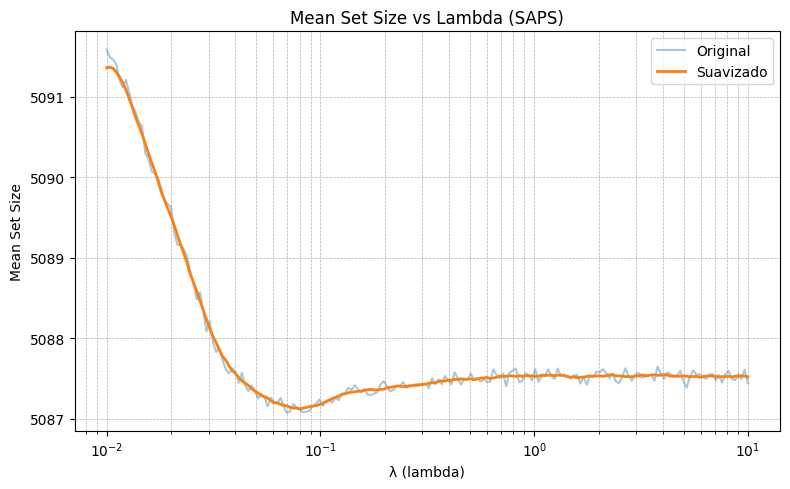

0.08026433522257174


In [186]:
n = 200

x = np.linspace(-2, 1, n)
lambdas = 10 ** x

results = torch.zeros(n)

for i, lmbda in enumerate(lambdas):
    q_hat = model._calibrate_SAPS(valid_pred_scores, valid_true_labels, lmbda, ALPHA)
    valid_pred_sets = model._inference_SAPS(valid_pred_scores, q_hat, lmbda)
    results[i] = mean_set_score(valid_pred_sets, valid_true_labels, ALPHA)
    
def smooth_reflect(y, window_size=5):
    pad_size = window_size // 2
    y_padded = np.pad(y, pad_width=pad_size, mode='reflect')
    kernel = np.ones(window_size) / window_size
    y_smooth = np.convolve(y_padded, kernel, mode='valid')
    return y_smooth

smoothed_results = smooth_reflect(results.numpy(), window_size=11)
lambda_reg = lambdas[np.argmin(smoothed_results)]

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(lambdas, results.numpy(), label='Original', alpha=0.4)
plt.plot(lambdas, smoothed_results, label='Suavizado', linewidth=2)
plt.xscale('log')
plt.xlabel('λ (lambda)')
plt.ylabel('Mean Set Size')
plt.title('Mean Set Size vs Lambda (SAPS)')
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print(lambda_reg)

In [187]:
# lambda_reg=0.2

### CALIBRATION

In [188]:
# Obtiene el número de instancias del conjunto y el número de clases
n, num_classes = calib_pred_scores.shape

# Ordena los scores de mayor a menor y calcula la suma acumulada
sorted_scores, sorted_class_perm_index = torch.sort(calib_pred_scores, dim=1, descending=True)

# Encuentra, para cada instancia, la posición (0-indexed) de la clase verdadera en el ranking
matches = (sorted_class_perm_index == calib_true_labels.unsqueeze(1))
true_class_rank = matches.int().argmax(dim=1)  # (n,)

#
max_score = sorted_scores[torch.arange(n), 0]

# Genera un vector de valores aleatorios entre 0 y 1, uno por instancia 
U = torch.rand(n)

# Calcula los nonconformity scores ajustando con ruido aleatorio (si la clase verdadera no está al principio)
nonconformity_scores = torch.where(
    true_class_rank >= 1,
    max_score + (true_class_rank-1+U)*lambda_reg, #------------
    max_score * U
)

# Calcula el nivel de cuantificación ajustado basado en el tamaño del conjunto de calibración y alpha
q_level = math.ceil((1.0 - ALPHA) * (n + 1.0)) / n

# Calcula el umbral de no conformidad como el percentil q_level de los valores de conformidad 
q_hat = torch.quantile(nonconformity_scores, q_level, interpolation='higher').item()

print(q_hat)

0.7973940372467041


### TEST

In [ ]:
# Determina la clase predicha como la clase con mayor puntuación
_, test_pred_labels = torch.max(test_pred_scores, dim=1) 

# Obtiene el número de instancias del conjunto y el número de clases
n, num_classes = test_pred_scores.shape

# Ordena los scores de mayor a menor 
sorted_scores, sorted_class_perm_index = torch.sort(test_pred_scores, dim=1, descending=True)

#
max_score = sorted_scores[torch.arange(n), 0]

# Genera un vector de valores aleatorios entre 0 y 1, uno por instancia 
U = torch.rand(n, generator=g)

# pos_matrix: (n, num_classes)
index_matrix = torch.arange(num_classes).expand(n, num_classes)

# U_matrix: (n, num_classes)
U_matrix = U.unsqueeze(1).expand(-1, num_classes)

#U_matrix = torch.rand(n, num_classes)

# 
nonconformity_scores = torch.where(
    index_matrix >= 1,
    max_score.unsqueeze(1) + ((index_matrix - 1 + U_matrix) * lambda_reg),
    U_matrix*max_score.unsqueeze(1)
)

#
inclusion_mask = nonconformity_scores <= q_hat

#
test_pred_sets = torch.zeros_like(test_pred_scores, dtype=torch.uint8)
test_pred_sets.scatter_(1, sorted_class_perm_index, inclusion_mask.to(torch.uint8))

# Asegura que siempre haya al menos una clase en el conjunto predicho
empty_sets = inclusion_mask.sum(dim=1) == 0
test_pred_sets[empty_sets] = 1  # selecciona todas las clases en esos casos

tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 1, 0],
        ...,
        [0, 0, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [217]:
# Calcula y muestra la exactitud
accry = (test_pred_labels == test_true_labels).sum() / test_true_labels.size(0)
print(f"Accuracy: {accry*100:>4.2f} %")

# Calcula y muestra la cobertura empírica 
ec = empirical_coverage_classification(test_pred_sets, test_true_labels)
print(f"Cobertura empírica: {ec*100:>4.2f} %")

# Calcula y muestra el tamaño medio del conjunto
mss = mean_set_size(test_pred_sets)
print(f"Tamaño medio de conjunto: {mss:>4.2f}")

Accuracy: 25.79 %
Cobertura empírica: 94.10 %
Tamaño medio de conjunto: 6.19


In [218]:
#
num_labels, num_instances, coverage = each_size_coverage(test_pred_sets, test_true_labels)
for l, i, c in zip(num_labels, num_instances, coverage):
    print(f"Número de etiquetas: {l}, Instancias: {i}, Cobertura: {(c*100):.2f}%")

Número de etiquetas: 0, Instancias: 1, Cobertura: 0.00%
Número de etiquetas: 1, Instancias: 14, Cobertura: 57.14%
Número de etiquetas: 2, Instancias: 22, Cobertura: 90.91%
Número de etiquetas: 3, Instancias: 26, Cobertura: 100.00%
Número de etiquetas: 4, Instancias: 59, Cobertura: 88.14%
Número de etiquetas: 5, Instancias: 292, Cobertura: 92.12%
Número de etiquetas: 6, Instancias: 856, Cobertura: 94.98%
Número de etiquetas: 7, Instancias: 696, Cobertura: 94.40%
Número de etiquetas: 8, Instancias: 183, Cobertura: 96.72%
Número de etiquetas: 9, Instancias: 3, Cobertura: 100.00%
